<a href="https://colab.research.google.com/github/chrismartel/ECSE415-Project-G7/blob/main/classification/classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####Download Vehicle Dataset

In [1]:
!wget -O output https://mcgill-my.sharepoint.com/:u:/g/personal/raghav_mehta_mail_mcgill_ca/EVEvhY9_jyVEk2uSZ8wZhFYBQ58C57I7ZB55jBocKwB5Jg?download=1
!mv output dataset.zip
!unzip dataset.zip
!rm dataset.zip

--2022-03-23 19:28:04--  https://mcgill-my.sharepoint.com/:u:/g/personal/raghav_mehta_mail_mcgill_ca/EVEvhY9_jyVEk2uSZ8wZhFYBQ58C57I7ZB55jBocKwB5Jg?download=1
Resolving mcgill-my.sharepoint.com (mcgill-my.sharepoint.com)... 13.107.136.9, 13.107.138.9
Connecting to mcgill-my.sharepoint.com (mcgill-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/raghav_mehta_mail_mcgill_ca/Documents/dataset.zip [following]
--2022-03-23 19:28:06--  https://mcgill-my.sharepoint.com/personal/raghav_mehta_mail_mcgill_ca/Documents/dataset.zip
Reusing existing connection to mcgill-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 826880986 (789M) [application/x-zip-compressed]
Saving to: ‘output’

output              100%[===================>] 788.57M  36.7MB/s    in 24s     

2022-03-23 19:28:31 (32.5 MB/s) - ‘output’ saved [826880986/826880986]

Archive:  dataset.zip
replace dataset/0000.txt? [y]es, [n]o, [A]

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import cv2 as cv

def parse(filepath):
  '''
      Parse gt.txt with format
        <frame>, <id>, <type>, <truncated>, <occluded>, <alpha>, <bb_left>, <bb_top>, <bb_right>, <bb_bottom>, <3D_H>, <3D_W>, <3D_L>, <x>, <y>, <z>, <ry>
      Return dict as:
        <type> = "Car", "Van", "Truck", "Pedastrian", "Person_sitting", "Cyclist", "Tram", "Misc", "DontCare"
        key: frame
        value: list - <id>, <bb_left>, <bb_top>, <bb_right>, <bb_bottom>, <is_vehicle>
      Feel free to edit your structure as needed!
  '''

  used_type = ["Car", "Van", "Truck", "Tram"]

  lines = open(filepath, "r").readlines()                                 
  bbox = {}

       #  <frame>, <id>, <truncated>, <occluded>, <alpha>, <bb_left>, <bb_top>, <bb_right>, <bb_bottom>, <3D_H>, <3D_W>, <3D_L>, <x>,   <y>,   <z>,   <ry>
  mask = [False,   True,  False,       False,      False,   True,      True,     True,       True,        False,  False,  False,  False, False, False, False]
  
  for line in lines:
    l = line.strip().split(' ') #convert line to list
    typ = l.pop(2)  # get type of bbox 
    line = np.asarray(l).astype(np.float32) # convert into array 
    frame, line = int(line[0]), line[mask] # get frame number and mask the line   
    if frame not in bbox.keys():
      bbox[frame] = []   
    if typ in used_type:
        bbox[frame].append(line)
  return bbox

def add_bbox(img, bbox, color=(255, 0, 0), thickness=2):
  ''' 
    annotate an image with bounding boxes:
    supports single bbox or list of bboxs
  '''

  annotated = np.copy(img)
  if bbox: 
    if isinstance(bbox[0], np.ndarray) or isinstance(bbox[0], list):
        for (_,x1,y1,x2,y2) in bbox:
            cv.rectangle(annotated, (x1, y1), (x2, y2), color , thickness)
    else:
        _,x1,y1,x2,y2 = bbox
        cv.rectangle(annotated, (x1, y1), (x2, y2), color , thickness)
  
  return annotated

In [3]:
"""
Check if two rectangle intersect in a x-y coordinate system.
r1: tuple (x1,y1,x2,y2) coordinates of rectangle 1
r2: tuple (x1,y1,x2,y2) coordinates of rectangle 2
return True if r1 and r2 interesect False otherwise.
"""
def intersection(r1, r2):
  if r1[0] >= r2[2] or r1[2] <= r2[0] or r1[1] >= r2[3] or r1[3] <= r2[1]:
    return False
  else:
    return True


##**Build Dataset**


###Positive Dataset

Use provided bounding boxes from train dataset

###Negative Dataset

Use different objects from random patches in train dataset

In [51]:
from matplotlib.cbook import maxdict
import os
import cv2 as cv
from random import randint

number_of_sequences = 4

sequences = list()

number_of_negative_samples_per_sequence = 50

minimum_bbox_h, maximum_bbox_h = 40, 150
minimum_bbox_w, maximum_bbox_w = 50, 200

max_diff_width_height = 20

number_of_samples = 0

for image_sequence in range(number_of_sequences):

  samples = list()

  visited_ids = list()

  bboxes = parse('dataset/000{image_sequence}.txt'.format(image_sequence=image_sequence))

  # Get positive samples from whole sequence
  for frame_id, frame_bboxes in bboxes.items():

    img = cv.imread('dataset/000{image_sequence}/{frame_id:06d}.png'.format(image_sequence=image_sequence, frame_id=frame_id))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    for bbox in frame_bboxes:
      id, x1, y1, x2, y2 = bbox.astype('int32')

      if id not in visited_ids:
        visited_ids.append(id)
        bbox_img = img[y1:y2,x1:x2]
        samples.append((bbox_img,1))

  # Generate negative samples
  for sample in range(number_of_negative_samples_per_sequence):

      frame_id = randint(0,len(bboxes.keys()))
      frame_bboxes = bboxes[frame_id]
      
      img = cv.imread('dataset/000{image_sequence}/{frame_id:06d}.png'.format(image_sequence=image_sequence, frame_id=frame_id))
      img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

      while(True):
        random_y1 = randint(0,img.shape[0])
        random_y2 = randint(random_y1,img.shape[0])

        random_x1 = randint(0,img.shape[1])
        random_x2 = randint(random_x1,img.shape[1])

        # validate dimensions
        if random_y2 - random_y1 < minimum_bbox_h or random_y2 - random_y1 > maximum_bbox_h:
          continue
        if random_x2 - random_x1 < minimum_bbox_h or random_x2 - random_x1 > maximum_bbox_w:
          continue

        if abs((random_x2 - random_x1) - (random_y2 - random_y1)) > max_diff_width_height:
          continue

        random_bbox = (random_x1, random_y1, random_x2, random_y2)

        # validate no-intersection with vehicles
        valid = True
        for (id, x1,y1,x2,y2) in frame_bboxes:
          if intersection((x1,y1,x2,y2), random_bbox):
            valid = False
            break

        if valid:
          break

      # extract patch
      random_bbox_img = img[random_y1:random_y2,random_x1:random_x2]
      samples.append((random_bbox_img,0))

  sequences.append(samples)
  number_of_samples += len(samples)

####Dataset Statistics

- Aspect Ratio
- Image Sizes

In [52]:
import numpy as np

# Number of samples
number_of_samples = 0
for seq in sequences:
  number_of_samples += len(seq)

# Class distribution
class_count = np.zeros(2)

# compute statistics on full image dataset
aspect_ratios = np.zeros(number_of_samples)
min_aspect_ratio, max_aspect_ratio = np.iinfo(np.int32).max, 0

widths = np.zeros(number_of_samples)
min_width, max_width = np.iinfo(np.int32).max, 0

heights = np.zeros(number_of_samples)
min_height, max_height = np.iinfo(np.int32).max, 0

for seq in sequences:
  for i, (sample,label) in enumerate(seq):
    widths[i] = sample.shape[1]
    min_width = widths[i] if widths[i] < min_width else min_width
    max_width = widths[i] if widths[i] > max_width else max_width

    heights[i] = sample.shape[0]
    min_height = heights[i] if heights[i] < min_height else min_height
    max_height = widths[i] if widths[i] > max_height else max_height

    aspect_ratios[i] = heights[i] / float(widths[i])
    min_aspect_ratio = aspect_ratios[i] if aspect_ratios[i] < min_aspect_ratio else min_aspect_ratio
    max_aspect_ratio = aspect_ratios[i] if aspect_ratios[i] > max_aspect_ratio else max_aspect_ratio

    class_count[label] += 1

aspect_ratio_interval = int(max_aspect_ratio - min_aspect_ratio)
width_interval = int(max_width - min_width)
height_interval = int(max_height - min_height)

aspect_ratio_banks = range(int(min_aspect_ratio), int(max_aspect_ratio), aspect_ratio_interval)
width_banks = range(int(min_width), int(max_width), width_interval)
height_banks = range(int(min_height), int(max_height), height_interval)

# Todo display number of instances in each range

####Class Distribution

Display number of vehicle and non-vehicle images in dataset

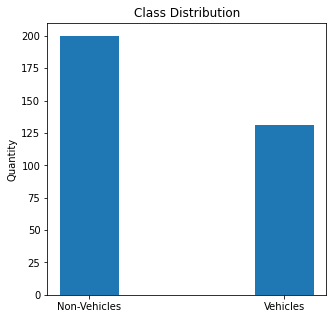

In [53]:
plt.figure(figsize=(5,5))
plt.bar(['Non-Vehicles','Vehicles'],class_count, width=0.3)
plt.ylabel('Quantity')
plt.title("Class Distribution")
plt.show()

##**Image Preprocessing**



*   Resize Images
*   Normalize Images
*   Extract HoG Features
*   Add Noise?






In [54]:
from skimage.transform import resize
from skimage.feature import hog
import numpy as np
from random import shuffle

'''
Preprocess a series of extracted image from an image sequence. 
image_sequences: dict - Each key contains a list of tuples. Each tuple has the following format (np.array(h,w,3), integer label)
resize_shape: tuple (new_height, new_width) - resizing shape
orientations: int - number of orientation bins in hog feature computations
pixels_per_cells: tuple (h,w) - number of pixels per cell in hog feature computation
cells_per_block: tuple (h,w) - number of cells per block in hog feature computation
return (features, labels) - features and labels are dict. Each key represents the sequence id.
'''
def preprocess(sequences, resize_shape, orientations, pixels_per_cell, cells_per_block):
  number_of_sequences = len(sequences)

  # compute number of hog features
  number_hog_features = len(hog(np.zeros(resize_shape), orientations=orientations, pixels_per_cell = pixels_per_cell, cells_per_block=cells_per_block, feature_vector=True))
  
  features = dict()
  labels = dict()

  for i, seq in enumerate(sequences):
    number_of_samples = len(seq) # number of image samples in sequence

    seq_features = np.zeros((number_of_samples, number_hog_features)) # x
    seq_labels = np.zeros(number_of_samples) # y

    for j, (sample, label) in enumerate(seq):
      # Resize image
      resized = resize(sample, resize_shape)

      # Min-max normalization
      min, max = np.min(resized), np.max(resized)
      normalized = (resized - min) / (max - min)

      # Extract HoG features
      seq_labels[j] = label
      seq_features[j] = hog(normalized, orientations=orientations, pixels_per_cell = pixels_per_cell, cells_per_block=cells_per_block, feature_vector=True, multichannel=True)

    # Shuffle
    inds = list(range(number_of_samples))
    shuffle(inds)
    seq_features = seq_features[inds]
    seq_labels = seq_labels[inds]

    features[i] = seq_features
    labels[i] = seq_labels

  return features, labels



###**3-Fold Cross-Validation**

For each validation, choose an image sequence to be the validation set

In [24]:
from random import shuffle
from sklearn import svm
import time

"""
Perform cross-validation for training SVM classifier for vehicle detection.
features: dictionary where keys are the image sequences ids and values are numpy arrays of features.
labels: dictionary where keys are the image sequences ids and value are numpy arrays of labels (1 for vehicle, 0 for non-vehcile)
K: number of folds. Must be a value between 1 and number of sequences.
C: parameter used for SVM training.
Return average accuracy
"""
def cross_validation(features, labels, K=3, C=10):

  number_of_sequences = len(features.keys())

  if K < 1 or K > number_of_sequences:
    print("Invalid K. Must be between 1 and number of image sequences.")
    return

  # performance measures
  tp, fp, tn, fn, inference_execution_times = np.zeros(K), np.zeros(K), np.zeros(K), np.zeros(K), np.zeros(K)

  inds = list(range(number_of_sequences))
  shuffle(inds)

  for k in range(K):
    # val dataset
    x_val, y_val = features[inds[k]], labels[inds[k]]

    # train dataset
    train_range = list(range(0,inds[k])) + list(range(inds[k]+1,number_of_sequences))
    x_train, y_train = None, None
    for i in train_range:
      if x_train is None:
        x_train = features[i]
      else:
        x_train = np.concatenate((x_train, features[i]), axis=0)

      if y_train is None:
        y_train = labels[i]
      else:
        y_train = np.concatenate((y_train, labels[i]), axis=0)

    # SVM Binary Classifier
    clf = svm.SVC(gamma='scale', C=C)
          
    # Train
    clf.fit(x_train, y_train)

    # Predict
    start = time.time()
    y_pred = clf.predict(x_val)
    end = time.time()
    inference_execution_times[k] = (end-start)

    # Performance measurements
    tp[k] = np.sum(np.logical_and(y_pred == 1, y_val == 1))
    fp[k] = np.sum(np.logical_and(y_pred == 1, y_val == 0))
    tn[k] = np.sum(np.logical_and(y_pred == 0, y_val == 0))
    fn[k] = np.sum(np.logical_and(y_pred == 0, y_val == 1))

  return np.sum(tp,axis=-1), np.sum(fp,axis=-1), np.sum(tn,axis=-1), np.sum(fn,axis=-1), np.mean(inference_execution_times)

In [48]:
# Performance Measures

def accuracy(tp, fp, tn, fn):
  return 100*(tp+tn)/(tp+fp+tn+fn)

def precision(tp, fp):
  return 100*tp/(tp+fp)

def recall(tp, fn):
  return 100*tp/(tp+fn)

In [59]:
# HoG parameters

# Input image size
W = 128
H = 80
orientations = 9 # number of orientation bins
pixels_per_cell = (4,4) # number of pixels per cell
cells_per_block = (2,2) # number of cells per block

# SVM Parameters
C = 2000

# 3-Fold CV
K = 3

# Preprocessing
features, labels = preprocess(sequences, (H,W), orientations, pixels_per_cell, cells_per_block)
tp, fp, tn, fn, inference_exec_time = cross_validation(features, labels, K=3, C=C)
print("recall: ",recall(tp,fn))
print("accuracy: ",accuracy(tp,fp, tn,fn))

recall:  38.65546218487395
accuracy:  71.00371747211896


###Vary Parameter C

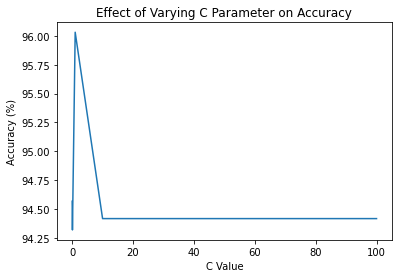

Best accuracy: 96.0310%
C: 1


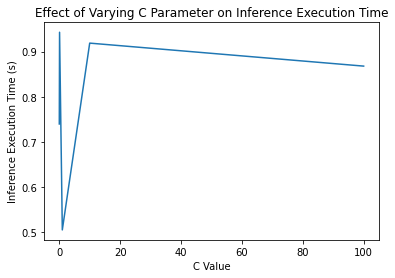

Best Inference Execution Time: 0.9427s
C: 1


In [50]:
# HoG parameters

# Input image size
W = 128
H = 80
orientations = 9 # number of orientation bins
pixels_per_cell = (8,16) # number of pixels per cell
cells_per_block = (4,4) # number of cells per block

# 3-Fold CV
K = 3

param_range = [0.01, 0.1, 1, 10, 100]

recalls = np.zeros(len(param_range))
inference_exec_times = np.zeros(len(param_range))

features, labels = preprocess(sequences, (H,W), orientations, pixels_per_cell, cells_per_block)

for i, c in enumerate(param_range):
  tp, fp, tn, fn, inference_exec_times[i] = cross_validation(features, labels, K=K, C=c)
  recalls[i] = recall(tp,fn)


# Plot Recall
plt.plot(param_range,recalls)
plt.title("Effect of Varying C Parameter on Recall")
plt.xlabel("C Value")
plt.ylabel("Recall (%)")
plt.show()
print("Best recall: {acc:.4f}%\nC: {c}".format(acc=np.max(recalls), c=param_range[np.argmax(recalls)]))

# Plot Inference Execution Times
plt.plot(param_range,inference_exec_times)
plt.title("Effect of Varying C Parameter on Inference Execution Time")
plt.xlabel("C Value")
plt.ylabel("Inference Execution Time (s)")
plt.show()
print("Best Inference Execution Time: {inf:.4f}s\nC: {c}".format(inf=np.max(inference_exec_times), c=param_range[np.argmin(inference_exec_times)]))

###Vary HoG Block Shape

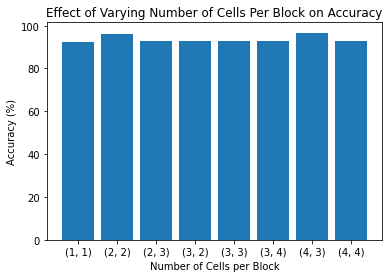

Best accuracy: 96.7112%
Cells per block: (4,3)


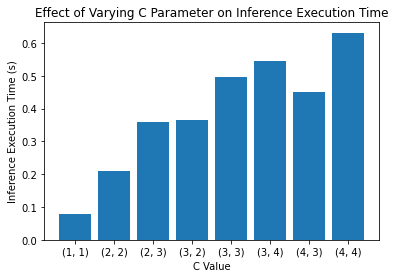

Best Inference Execution Time: 0.6314s
Cells per block: (1,1)


In [33]:
# HoG parameters

# Input image size
W = 128
H = 80
orientations = 9 # number of orientation bins
pixels_per_cell = (8,16) # number of pixels per cell

# SVM Parameters
C = 1

# 3-Fold CV
K = 3

param_range = [(1,1),(2,2),(2,3),(3,2),(3,3),(3,4),(4,3),(4,4)]

recalls = np.zeros(len(param_range))
inference_exec_times = np.zeros(len(param_range))

for i, cells_per_block in enumerate(param_range):
  features, labels = preprocess(sequences, (H,W), orientations, pixels_per_cell, cells_per_block)
  tp, fp, tn, fn, inference_exec_times[i] = cross_validation(features, labels, K=K, C=C)
  recalls[i] = recall(tp,fn)

param_range_str = [str(x) for x in param_range]

# Plot Recall
plt.bar(param_range_str,recalls)
plt.title("Effect of Varying Number of Cells Per Block on Recall")
plt.xlabel("Number of Cells per Block")
plt.ylabel("Recall (%)")
plt.show()
best = param_range[np.argmax(recalls)]
print("Best recall: {acc:.4f}%\nCells per block: ({h},{w})".format(acc=np.max(recalls), h=best[0], w=best[1]))

# Plot Inference Execution Times
plt.bar(param_range_str,inference_exec_times)
plt.title("Effect of Varying C Parameter on Inference Execution Time")
plt.xlabel("Number of Cells per Block")
plt.ylabel("Inference Execution Time (s)")
plt.show()
best = param_range[np.argmin(inference_exec_times)]
print("Best Inference Execution Time: {inf:.4f}s\nCells per block: ({h},{w})".format(inf=np.max(inference_exec_times), h=best[0], w=best[1]))

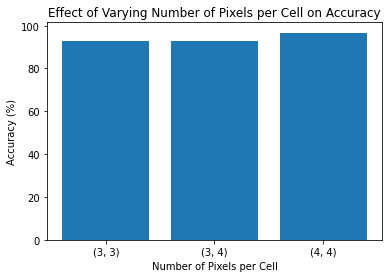

Best accuracy: 96.7112%
Pixels per Cell: (4,4)


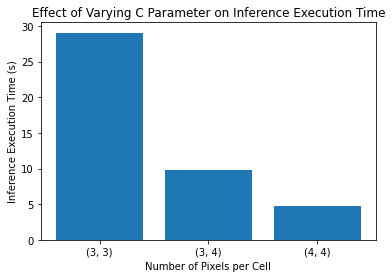

Best Inference Execution Time: 29.0596s
Pixels per Cell: (4,4)


In [35]:
# HoG parameters

# Input image size
W = 128
H = 80
orientations = 9 # number of orientation bins

cells_per_block = (2,2)

# pixels_per_cell = () # number of pixels per cell

# SVM Parameters
C = 1

# 3-Fold CV
K = 3

param_range = [(4,4),(6,6),(8,8)]

recalls = np.zeros(len(param_range))
inference_exec_times = np.zeros(len(param_range))

for i, pixels_per_cell in enumerate(param_range):
  features, labels = preprocess(sequences, (H,W), orientations, pixels_per_cell, cells_per_block)
  tp, fp, tn, fn, inference_exec_times[i] = cross_validation(features, labels, K=K, C=C)
  recalls[i] = recall(tp,fn)

param_range_str = [str(x) for x in param_range]

# Plot Accuracies
plt.bar(param_range_str,recalls)
plt.title("Effect of Varying Number of Pixels per Cell on Recall")
plt.xlabel("Number of Pixels per Cell")
plt.ylabel("Recall (%)")
plt.show()
best = param_range[np.argmax(recalls)]
print("Best recall: {acc:.4f}%\nPixels per Cell: ({h},{w})".format(acc=np.max(recalls), h=best[0], w=best[1]))

# Plot Inference Execution Times
plt.bar(param_range_str,inference_exec_times)
plt.title("Effect of Varying C Parameter on Inference Execution Time")
plt.xlabel("Number of Pixels per Cell")
plt.ylabel("Inference Execution Time (s)")
plt.show()
best = param_range[np.argmin(inference_exec_times)]
print("Best Inference Execution Time: {inf:.4f}s\nPixels per Cell: ({h},{w})".format(inf=np.max(inference_exec_times), h=best[0], w=best[1]))